In [1]:
from sklearn.datasets import fetch_20newsgroups
categories = ["alt.atheism", "soc.religion.christian", "comp.graphics", "sci.med"]
raw_data = fetch_20newsgroups(subset = "train", categories = categories, shuffle = True, random_state = 42)

In [2]:
label = raw_data.target
label_name = [raw_data.target_names[i] for i in raw_data.target]

In [3]:
print(len(raw_data.data))
print(label[:5])
print(label_name[:5])
print(raw_data.data[0])
print(raw_data.filenames[0])
print(raw_data.target[0])
print(raw_data.target_names[raw_data.target[0]])

2257
[1 1 3 3 3]
['comp.graphics', 'comp.graphics', 'soc.religion.christian', 'soc.religion.christian', 'soc.religion.christian']
From: sd345@city.ac.uk (Michael Collier)
Subject: Converting images to HP LaserJet III?
Nntp-Posting-Host: hampton
Organization: The City University
Lines: 14

Does anyone know of a good way (standard PC application/PD utility) to
convert tif/img/tga files into LaserJet III format.  We would also like to
do the same, converting to HPGL (HP plotter) files.

Please email any response.

Is this the correct group?

Thanks in advance.  Michael.
-- 
Michael Collier (Programmer)                 The Computer Unit,
Email: M.P.Collier@uk.ac.city                The City University,
Tel: 071 477-8000 x3769                      London,
Fax: 071 477-8565                            EC1V 0HB.

/home/spenser/scikit_learn_data/20news_home/20news-bydate-train/comp.graphics/38440
1
comp.graphics


In [4]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
count_data = count_vect.fit_transform(raw_data.data)
print(count_data.shape)

(2257, 35788)


In [5]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
tfidf_data = tfidf_transformer.fit_transform(count_data)
print(tfidf_data.shape)

(2257, 35788)


In [6]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
print(tf.__version__)

/home/spenser/.conda/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/spenser/.conda/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/spenser/.conda/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/spenser/.conda/envs/gpu/lib/python3.7/site-packages/ten

1.13.1


In [7]:
class Autoencoder:
    def __init__(self, input_dim, hidden_dim, epoch, batch_size, learning_rate=0.001):
        self.epoch = epoch
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        x = tf.placeholder(dtype=tf.float32, shape=[None, input_dim])
        
        with tf.name_scope('encode'):
            weights = tf.Variable(tf.random_normal([input_dim, hidden_dim], dtype=tf.float32), name='weights')
            biases = tf.Variable(tf.zeros([hidden_dim]), name='biases')
            encoded = tf.nn.sigmoid(tf.add(tf.matmul(x, weights), biases))
            
        with tf.name_scope('decode'):
            weights = tf.Variable(tf.random_normal([hidden_dim, input_dim], dtype=tf.float32), name='weights')
            biases = tf.Variable(tf.zeros([input_dim]), name='biases')
            decoded = tf.nn.sigmoid(tf.add(tf.matmul(encoded, weights), biases))
        
        self.x = x
        self.encoded = encoded
        self.decoded = decoded
        self.loss = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(self.x, self.decoded))))
        self.train_op = tf.train.RMSPropOptimizer(self.learning_rate).minimize(self.loss)
        self.saver = tf.train.Saver()

    def get_batch(self, X, size):
        a = np.random.choice(X.shape[0], size, replace=False)
        return X[a]

    def train(self, train_data, test_data = None):
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for i in range(self.epoch):
                Loss = 0
                count = 0
                for j in range(train_data.shape[0] // self.batch_size):
                    batch_data = self.get_batch(train_data, self.batch_size)
                    train_l, _ = sess.run([self.loss, self.train_op], feed_dict={self.x:batch_data.toarray()})
                    Loss += train_l
                    count += 1
                if test_data is not None:
                    test_l = sess.run([self.loss], feed_dict={self.x:test_data.toarray()})
                else:
                    test_l = None
                print('epoch {0}: train_loss = {1}, test_loss = {2}'.format(i+1, Loss/count, test_l))
                self.saver.save(sess, './Autoencoder.ckpt')
            self.saver.save(sess, './Autoencoder.ckpt')
            
    def encode_decode(self, data):
        with tf.Session() as sess:
            self.saver.restore(sess, "./Autoencoder.ckpt")
            hidden, reconstructed = sess.run([self.encoded, self.decoded], feed_dict={self.x:data.toarray()})
            return hidden, reconstructed

In [22]:
hidden_dim = 500
#train_data = tfidf_data[:-200]
train_data = tfidf_data
test_data = tfidf_data[-200:]
print(train_data.shape)
input_dim = train_data.shape[1]
print(input_dim)
ae = Autoencoder(input_dim = input_dim, hidden_dim = hidden_dim, epoch = 30, batch_size = 50)

(2257, 35788)
35788


In [9]:
print(train_data.shape)
train_data

(2057, 35788)


<2057x35788 sparse matrix of type '<class 'numpy.float64'>'
	with 334660 stored elements in Compressed Sparse Row format>

In [23]:
ae.train(train_data)

epoch 1: train_loss = 0.6830602910783555, test_loss = None
epoch 2: train_loss = 0.6830796255005731, test_loss = None
epoch 3: train_loss = 0.6830558194054498, test_loss = None
epoch 4: train_loss = 0.6826465169588725, test_loss = None
epoch 5: train_loss = 0.6790744105974833, test_loss = None
epoch 6: train_loss = 0.6655146638552348, test_loss = None
epoch 7: train_loss = 0.6471920172373454, test_loss = None
epoch 8: train_loss = 0.6283495042059156, test_loss = None
epoch 9: train_loss = 0.6094644043180678, test_loss = None
epoch 10: train_loss = 0.5906624899970161, test_loss = None
epoch 11: train_loss = 0.5720583902464973, test_loss = None
epoch 12: train_loss = 0.5542071011331346, test_loss = None
epoch 13: train_loss = 0.5370381500985887, test_loss = None
epoch 14: train_loss = 0.5208691332075331, test_loss = None
epoch 15: train_loss = 0.5055443710751004, test_loss = None
epoch 16: train_loss = 0.4913873732089996, test_loss = None
epoch 17: train_loss = 0.47861573100090027, test_

In [24]:
compressed_vectors, reconstructed_vectors = ae.encode_decode(train_data)

INFO:tensorflow:Restoring parameters from ./Autoencoder.ckpt


(2257, 2)
(2257,)


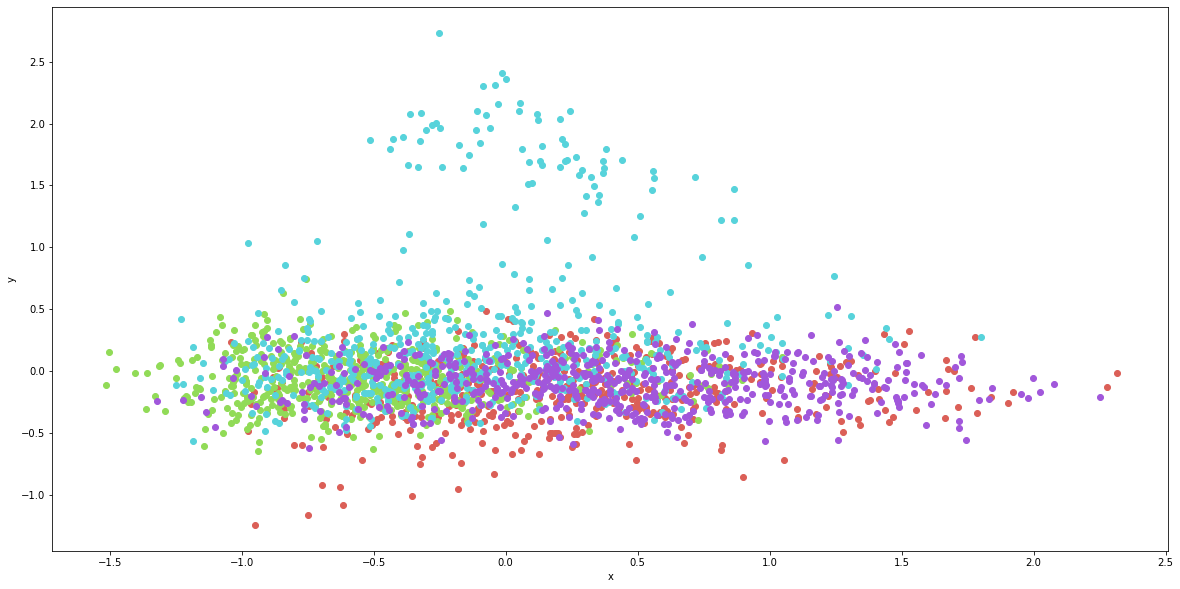

In [26]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
vectors2D = np.array(pca.fit(compressed_vectors).transform(compressed_vectors))
#test_label = np.array(label[-200:])
train_label = np.array(label)



#test_label_name = np.array(label_name[-200:])
train_label_name = np.array(label_name)


print(vectors2D.shape)
print(train_label.shape)
(200, 2)
(200,)
import seaborn as sns
colors = sns.color_palette("hls", 4).as_hex()
plt.figure(figsize=(20,10))
for i in range(4):
    plt.scatter(
        vectors2D[train_label == i][:,0],
        vectors2D[train_label == i][:,1],
        color=colors[i],
        alpha=1
    )
plt.xlabel('x')
plt.ylabel('y')
plt.show()